In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data_no_processing.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import phys_grad


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


In [3]:
kmday_to_ms = 1000 / 86400

# --- top-centre displacements + propagation speed ---
df_eddies['dx_top'] = df_eddies.groupby('Eddy')['xc'].diff()
df_eddies['dy_top'] = df_eddies.groupby('Eddy')['yc'].diff()
df_eddies['EddyProp'] = np.hypot(df_eddies['dx_top'], df_eddies['dy_top']) * kmday_to_ms

# --- bottom-centre positions (single pass) ---
df_idx = df_eddies.set_index(['Eddy', 'Day'])

x_btm, y_btm = [], []
for eddy, dic in dic_eddies_vert.items():
    eddy_id = int(eddy[4:])  # "Eddy####" -> ####
    for day, df in dic.items():
        day_id = int(day[3:])  # "Day##" -> ##
        if len(df):
            d = df[df.Depth.abs() < 1000]
            row = (d.iloc[-1] if len(d) else df.iloc[-1])
            x_btm.append(row.x)
            y_btm.append(row.y)
        else:
            row = df_idx.loc[(eddy_id, day_id)]
            x_btm.append(row.xc)
            y_btm.append(row.yc)

df_eddies['x_btm'] = x_btm
df_eddies['y_btm'] = y_btm

# --- bottom-centre displacements + propagation speed ---
df_eddies['dx_btm'] = df_eddies.groupby('Eddy')['x_btm'].diff()
df_eddies['dy_btm'] = df_eddies.groupby('Eddy')['y_btm'].diff()
df_eddies['btm_prop'] = np.hypot(df_eddies['dx_btm'], df_eddies['dy_btm']) * kmday_to_ms

# # --- separation and separation rate ---
# df_eddies['sep_km'] = np.hypot(df_eddies['x_btm'] - df_eddies['xc'],
#                                df_eddies['y_btm'] - df_eddies['yc'])
# df_eddies['sep_rate_ms'] = df_eddies.groupby('Eddy')['sep_km'].diff() * kmday_to_ms

# # --- optional: vector difference between top and bottom (m/s) ---
# df_eddies['top_btm_diff'] = np.hypot(df_eddies['dx_btm'] - df_eddies['dx_top'],
#                                      df_eddies['dy_btm'] - df_eddies['dy_top']) * kmday_to_ms



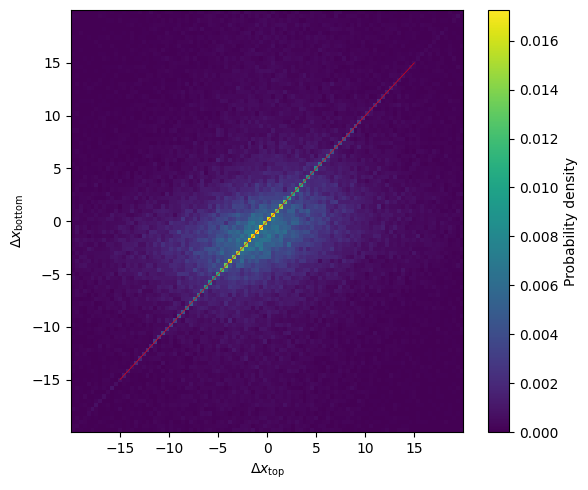

In [4]:
x = df_eddies.dx_top
y = df_eddies.dx_btm

mask = (np.abs(x) < 20) & (np.abs(y) < 20)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=100, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'$\Delta x_{\mathrm{top}}$')
plt.ylabel(r'$\Delta x_{\mathrm{bottom}}$')

plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()


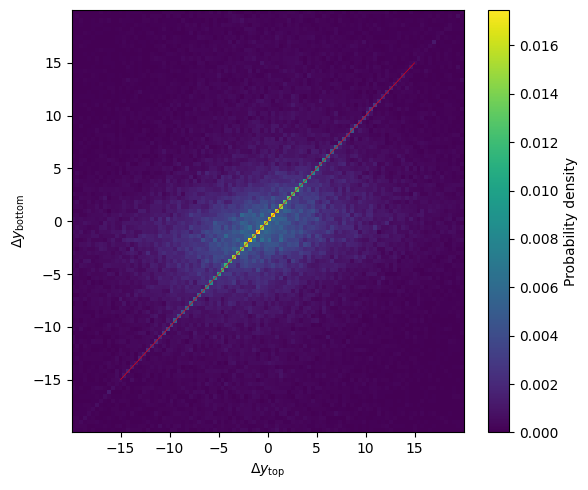

In [5]:
x = df_eddies.dy_top
y = df_eddies.dy_btm

mask = (np.abs(x) < 20) & (np.abs(y) < 20)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=100, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'$\Delta y_{\mathrm{top}}$')
plt.ylabel(r'$\Delta y_{\mathrm{bottom}}$')

plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()


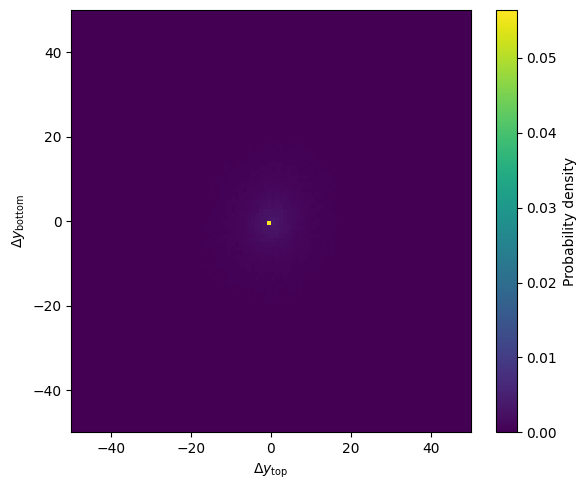

In [6]:
x = df_eddies.dx_top - df_eddies.dx_btm
y = df_eddies.dy_top - df_eddies.dy_btm

mask = (np.abs(x) < 50) & (np.abs(y) < 50)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=100, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'$\Delta y_{\mathrm{top}}$')
plt.ylabel(r'$\Delta y_{\mathrm{bottom}}$')

# plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()



In [7]:
x.max(), y.max()

(np.float64(161.12915020495097), np.float64(191.2046257710963))

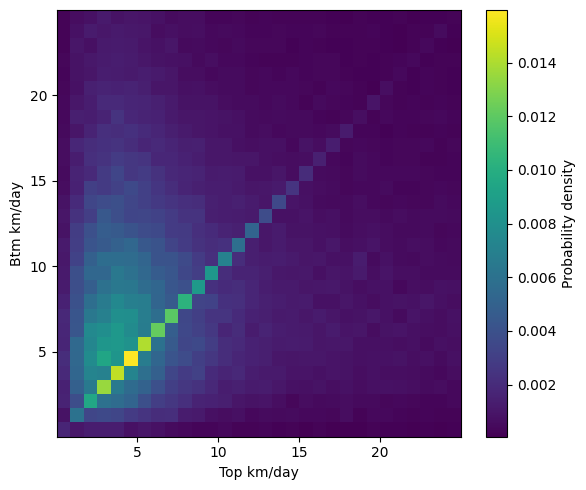

In [8]:
x = np.hypot(df_eddies.dx_btm,  df_eddies.dy_btm)
y = np.hypot(df_eddies.dx_top,  df_eddies.dy_top)

mask = (np.abs(x) < 25) & (np.abs(y) < 25)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=30, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'Top km/day')
plt.ylabel(r'Btm km/day')

# plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()



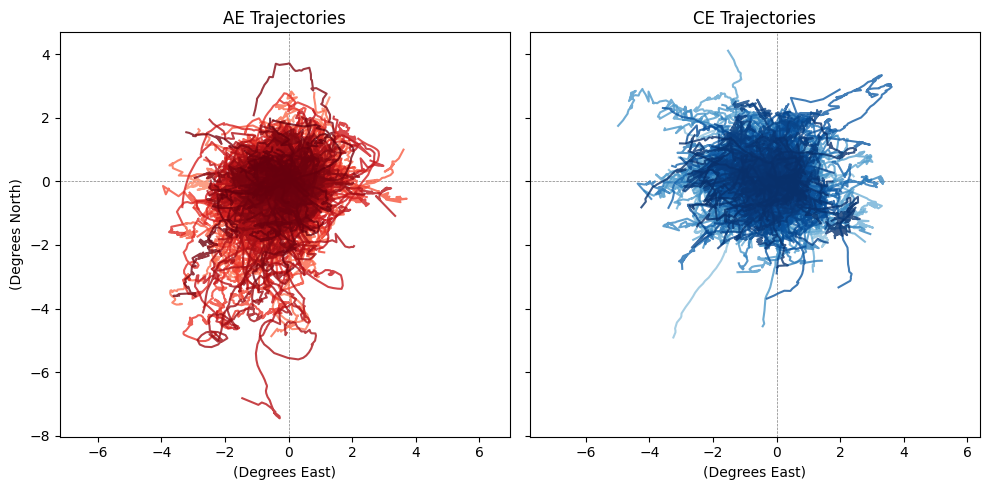

In [9]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
for ax in axs:
    ax.axhline(y=0, color='k', ls='--', alpha=.5, lw=.5)
    ax.axvline(x=0, color='k', ls='--', alpha=.5, lw=.5)
# separate groups
ae = [e for e in df_eddies.Eddy.unique() if df_eddies[df_eddies.Eddy==e].iloc[0].Cyc == 'AE']
ce = [e for e in df_eddies.Eddy.unique() if df_eddies[df_eddies.Eddy==e].iloc[0].Cyc != 'AE']

# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

for c, eddy in zip(colors_ae, ae):
    df = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df.Lon-df.iloc[0].Lon, df.Lat-df.iloc[0].Lat, color=c, alpha=0.8)

for c, eddy in zip(colors_ce, ce):
    df = df_eddies[df_eddies.Eddy==eddy]
    axs[1].plot(df.Lon-df.iloc[0].Lon, df.Lat-df.iloc[0].Lat, color=c, alpha=0.8)

axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_title('AE Trajectories')
axs[1].set_title('CE Trajectories')
axs[0].set_xlabel('(Degrees East)'); axs[0].set_ylabel('(Degrees North)')
axs[1].set_xlabel('(Degrees East)')

plt.tight_layout()
plt.show()


AE Below 0: 52.01 %
AE Above 0: 45.56 %
CE Below 0: 53.20 %
CE Above 0: 44.22 %


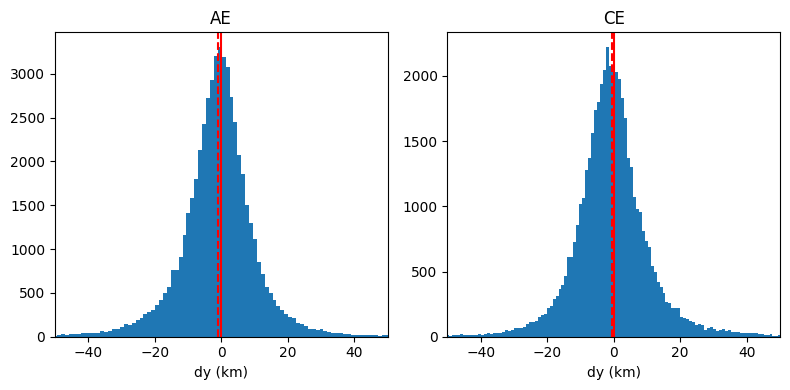

In [10]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].hist(df_AE.dy_top, bins=300)
axs[0].set_xlim(-50, 50)
axs[0].axvline(0, color='r') 
axs[0].axvline(df_AE.dy_top.mean(), color='r', ls='--') 
axs[0].set_title('AE'); axs[0].set_xlabel('dy (km)')
print(f'AE Below 0: {(df_AE.dy_top<=0).mean()*100:.2f} %')
print(f'AE Above 0: {(df_AE.dy_top>=0).mean()*100:.2f} %')

axs[1].hist(df_CE.dy_top, bins=300)
axs[1].set_xlim(-50, 50)
axs[1].axvline(0, color='r') 
axs[1].axvline(df_CE.dy_top.mean(), color='r', ls='--')
axs[1].set_title('CE'); axs[1].set_xlabel('dy (km)')
print(f'CE Below 0: {(df_CE.dy_top<=0).mean()*100:.2f} %')
print(f'CE Above 0: {(df_CE.dy_top>=0).mean()*100:.2f} %')

plt.tight_layout()


In [11]:
df_eddies['prop_mag'] = np.hypot(df_eddies.dx_top, df_eddies.dy_top)
df_eddies['prop_bearing'] = (np.degrees(np.arctan2(df_eddies.dx_top, df_eddies.dy_top)) + 360) % 360

df_eddies['prop_mag_btm'] = np.hypot(df_eddies.dx_btm, df_eddies.dy_btm)
df_eddies['prop_bearing_btm'] = (np.degrees(np.arctan2(df_eddies.dx_btm, df_eddies.dy_btm)) + 360) % 360

df_eddies['prop_mag_diff'] = np.hypot(df_eddies.dx_top - df_eddies.dx_btm, df_eddies.dy_top - df_eddies.dy_btm)
df_eddies['prop_bearing_diff'] = (np.degrees(np.arctan2(df_eddies.dx_top - df_eddies.dx_btm, df_eddies.dy_top - df_eddies.dy_btm)) + 360) % 360



In [12]:
def windrose(mag_name='prop_mag', brng_name='prop_bearing', df_data=df_eddies):
    
    df_AE = df_data[df_data.Cyc == 'AE'].copy()
    df_CE = df_data[df_data.Cyc == 'CE'].copy()
    
    def choose_dir_bins_cardinal(*dfs, col='TiltDir', min_bins=8, max_bins=36, min_avg_per_sector=8):
        candidates = np.array([4, 6, 8, 9, 10, 12, 15, 16, 18, 20, 24, 30, 36, 45, 60, 72])
        candidates = candidates[(candidates >= min_bins) & (candidates <= max_bins)]
        candidates = candidates[candidates % 4 == 0]  # ensures centres can hit N/E/S/W
    
        Ns = []
        for df in dfs:
            x = df[col].to_numpy()
            x = x[np.isfinite(x)]
            Ns.append(x.size)
        N = min(Ns) if Ns else 0
        if N == 0 or candidates.size == 0:
            k = 16
        else:
            k0 = int(np.ceil(2 * N ** (1/3)))  # Rice rule
            k = candidates[np.argmin(np.abs(candidates - k0))]
    
            while k > candidates.min() and (N / k) < min_avg_per_sector:
                k = candidates[candidates < k].max()
    
        dir_bins = np.linspace(0.0, 360.0, k + 1)
        shift = 180.0 / k  # half-bin shift -> centres at 0, 90, 180, 270
        return dir_bins, shift
    
    # --- bins ---
    dir_bins, dir_shift = choose_dir_bins_cardinal(df_AE, df_CE, col=brng_name, min_bins=8, max_bins=36, min_avg_per_sector=8)
    mag_bins = [0, 5, 10, 15, 20, np.inf]
    
    
    k = len(dir_bins) - 1
    binw_deg = 360.0 / k
    angles = np.deg2rad(np.arange(k) * binw_deg)   # centres: 0, binw, 2*binw, ...
    width = np.deg2rad(binw_deg)
    
    colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins) - 1))
    colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins) - 1))
    
    fig, axs = plt.subplots(
        1, 2,
        subplot_kw={'projection': 'polar'},
        figsize=(14, 6),
        constrained_layout=True
    )
    
    for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    
        directions = np.mod(df[brng_name].to_numpy(), 360.0)
        magnitudes = df[mag_name].to_numpy()
    
        mask = np.isfinite(directions) & np.isfinite(magnitudes)
        directions = directions[mask]
        magnitudes = magnitudes[mask]
    
        # shift so bins are centred on N/E/S/W
        directions_s = np.mod(directions + dir_shift, 360.0)
    
        dir_idx = np.digitize(directions_s, dir_bins, right=False) - 1
        mag_idx = np.digitize(magnitudes, mag_bins, right=False) - 1
    
        counts = np.zeros((len(mag_bins) - 1, k))
        for d_i, m_i in zip(dir_idx, mag_idx):
            if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
                counts[m_i, d_i] += 1
    
        bottom = np.zeros(k)
        for i in range(counts.shape[0]):
            ax.bar(
                angles, counts[i], width,
                bottom=bottom,
                color=colors1[i] if a == 0 else colors2[i],
                edgecolor=(0, 0, 0, 0.3),
                label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}'
            )
            bottom += counts[i]
    
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Prop. Dist. (km/day)')
    
        # ax.set_rlabel_position(270)
        ax.set_rticks([500, 1000, 1500])
    axs[0].set_rlabel_position(315); axs[1].set_rlabel_position(315)
    
    plt.show()
    

In [13]:
def binned_windrose(mag_name='prop_mag', brng_name='prop_bearing', df_data=df_eddies):
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    df_AE = df_eddies[df_eddies.Cyc == 'AE'].copy()
    df_CE = df_eddies[df_eddies.Cyc == 'CE'].copy()
    
    def choose_dir_bins_cardinal(*dfs, col=brng_name, min_bins=8, max_bins=36, min_avg_per_sector=8):
        candidates = np.array([4, 6, 8, 9, 10, 12, 15, 16, 18, 20, 24, 30, 36, 45, 60, 72])
        candidates = candidates[(candidates >= min_bins) & (candidates <= max_bins)]
        candidates = candidates[candidates % 4 == 0]
    
        Ns = []
        for df in dfs:
            x = df[col].to_numpy()
            x = x[np.isfinite(x)]
            Ns.append(x.size)
        N = min(Ns) if Ns else 0
    
        if N == 0 or candidates.size == 0:
            k = 16
        else:
            k0 = int(np.ceil(2 * N ** (1/3)))
            k = candidates[np.argmin(np.abs(candidates - k0))]
            while k > candidates.min() and (N / k) < min_avg_per_sector:
                k = candidates[candidates < k].max()
    
        dir_bins = np.linspace(0.0, 360.0, k + 1)
        shift = 180.0 / k
        return dir_bins, shift
    
    # ---------------- grid geometry ----------------
    ncols, nrows = 3, 4
    x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols + 1)
    y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows + 1)
    cell_w = (X_grid.max() - X_grid.min()) / ncols
    cell_h = (Y_grid.max() - Y_grid.min()) / nrows
    
    # ---------------- bins ----------------
    dir_bins, dir_shift = choose_dir_bins_cardinal(df_AE, df_CE, col=brng_name, min_bins=8, max_bins=36, min_avg_per_sector=8)
    mag_bins = [0, 5, 10, 15, 20, np.inf]
    
    k = len(dir_bins) - 1
    binw_deg = 360.0 / k
    angles = np.deg2rad(np.arange(k) * binw_deg)
    width = np.deg2rad(binw_deg)
    
    colors_cmps = [
        plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins) - 1)),
        plt.cm.Reds(np.linspace(0, 1, len(mag_bins) - 1)),
        plt.cm.Blues(np.linspace(0, 1, len(mag_bins) - 1)),
    ]
    
    def windrose_counts(directions_deg, magnitudes, *, dir_bins, mag_bins, dir_shift=0.0):
        d = np.asarray(directions_deg, float)
        m = np.asarray(magnitudes, float)
        mask = np.isfinite(d) & np.isfinite(m)
        d = d[mask]; m = m[mask]
        if d.size == 0:
            return None
    
        d = np.mod(d + dir_shift, 360.0)
        di = np.digitize(d, dir_bins, right=False) - 1
        mi = np.digitize(m, mag_bins, right=False) - 1
    
        c = np.zeros((len(mag_bins) - 1, len(dir_bins) - 1), float)
        ok = (0 <= di) & (di < c.shape[1]) & (0 <= mi) & (mi < c.shape[0])
        di = di[ok]; mi = mi[ok]
        for d_i, m_i in zip(di, mi):
            c[m_i, d_i] += 1
        return c
    
    def add_windrose(ax, x0, y0, c, rmax, colors, *, frac=0.45, tick_flag=False, title='', p=None):
        if c is None:
            return None
        s = frac * min(cell_w, cell_h)
        iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    
        bottom = np.zeros(k)
        for i in range(len(mag_bins) - 1):
            hi = "∞" if np.isinf(mag_bins[i + 1]) else f"{mag_bins[i + 1]:g}"
            label = f"{mag_bins[i]:g}–{hi}"
            iax.bar(angles, c[i], width, bottom=bottom, edgecolor=(0, 0, 0, 0.1), color=colors[i], label=label)
            bottom += c[i]
    
        iax.set_theta_zero_location('N')
        iax.set_theta_direction(-1)
        iax.set_rlim(0, rmax)
    
        if tick_flag:
            if p == 0:
                bbox_to_anchor = (-.39, -.29)
            elif p == 1:
                bbox_to_anchor = (-.17, -.1)
            elif p == 2:
                bbox_to_anchor = (-.17, -.1) #(-.25, -.15)
            else:
                bbox_to_anchor = (0, 0)
            iax.legend(title=title, loc='center left', frameon=True, fontsize=10, title_fontsize=10,
                       bbox_to_anchor=bbox_to_anchor, framealpha=.95)
    
        iax.set_xticks([])
        iax.set_yticks([])
        iax.set_frame_on(False)
        return iax
    
    def cell_counts(df):
        out, rmax = {}, 0.0
        for i in range(ncols):
            for j in range(nrows):
                x0, x1 = x_edges[i], x_edges[i + 1]
                y0, y1 = y_edges[j], y_edges[j + 1]
                sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
    
                d = np.asarray((sub[brng_name].to_numpy() - 20.0) % 360.0, float)
                m = np.asarray(sub[mag_name].to_numpy(), float)
    
                c = windrose_counts(d, m, dir_bins=dir_bins, mag_bins=mag_bins, dir_shift=dir_shift)
                out[(i, j)] = c
                if c is not None:
                    rmax = max(rmax, np.max(c.sum(axis=0)))
        return out, (1 if rmax == 0 else rmax)
    
    fracs = [1.5, 2.0, 2.0]
    fig, axs = plt.subplots(1, 3, figsize=(18, 9), sharey=True)
    
    titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
    for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
        ax = axs[p]
        df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]
    
        ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
        c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
        ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
        c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
        ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
        ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')
    
        ax.axis('equal')
        ax.set_xlim(X_grid.min(), X_grid.max())
        ax.set_ylim(Y_grid.min(), Y_grid.max())
    
        counts_map, rmax = cell_counts(df)
    
        for i in range(ncols):
            for j in range(nrows):
                if (i == 0) and (j == 2):
                    continue
    
                x0, x1 = x_edges[i], x_edges[i + 1]
                y0, y1 = y_edges[j], y_edges[j + 1]
                xc, yc = 0.5 * (x0 + x1), 0.5 * (y0 + y1)
    
                tick_flag = (i == 1) and (j == 3)
                add_windrose(ax, xc, yc, counts_map[(i, j)], rmax, colors_cmps[p],
                             frac=fracs[p], tick_flag=tick_flag,
                             title=' ' + titles[p] + ':\n Prop. Dist. (km/day)', p=p)
    
                if (i == 0) and (j == 2):
                    if p == 1:
                        add_windrose(ax, 120, 1130, counts_map[(i, j)], rmax/40, colors_cmps[p], frac=fracs[p])
                    else:
                        add_windrose(ax, 120, 1200, counts_map[(i, j)], rmax/10, colors_cmps[p], frac=fracs[p])
    
                ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)
    
        col_labels = ['A', 'B', 'C', 'D']
        for i in range(ncols):
            xmid = 0.5 * (x_edges[i] + x_edges[i + 1])
            ax.text(xmid, y_edges[-1] + 0.02 * (Y_grid.max() - Y_grid.min()),
                    col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
        for j in range(nrows):
            ymid = 0.5 * (y_edges[j] + y_edges[j + 1])
            alpha = .06 if p == 0 else .02
            ax.text(x_edges[0] - alpha * (X_grid.max() - X_grid.min()), ymid,
                    f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
    
    for ax in axs:
        ax.set_xlabel('x (km)')
    axs[0].set_ylabel('y (km)')
    plt.tight_layout()
    plt.show()
    

### Top propogation

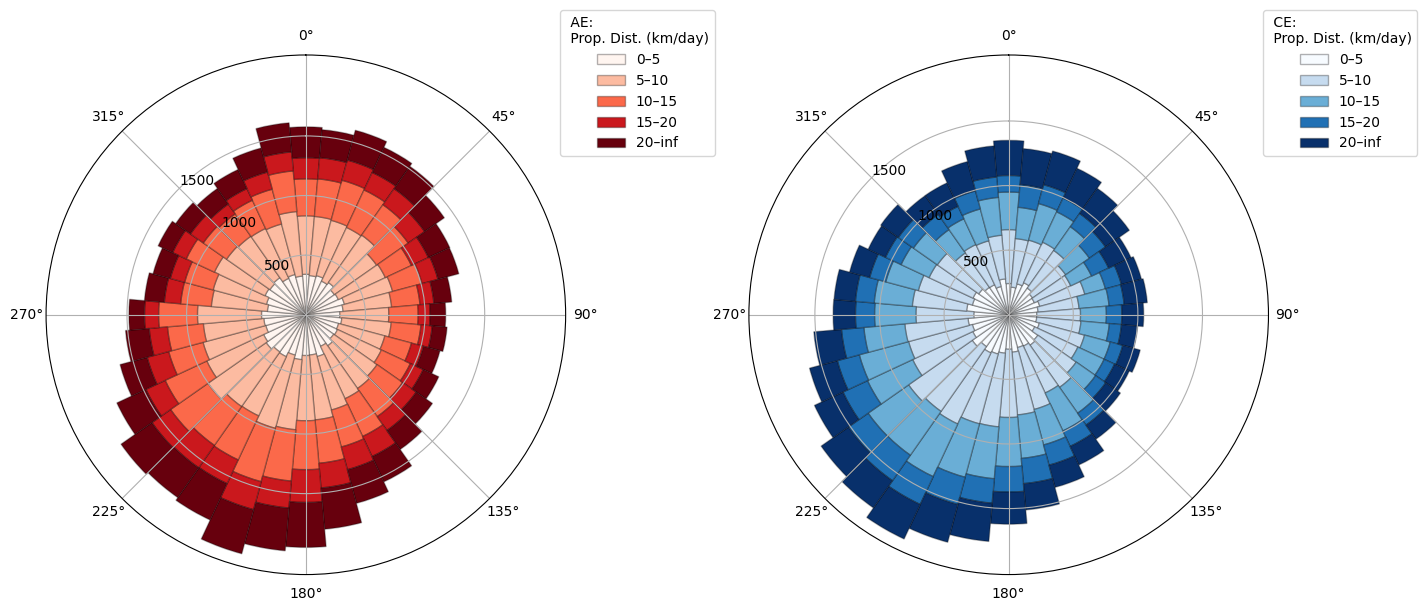

In [14]:
windrose(mag_name='prop_mag', brng_name='prop_bearing', df_data=df_eddies)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


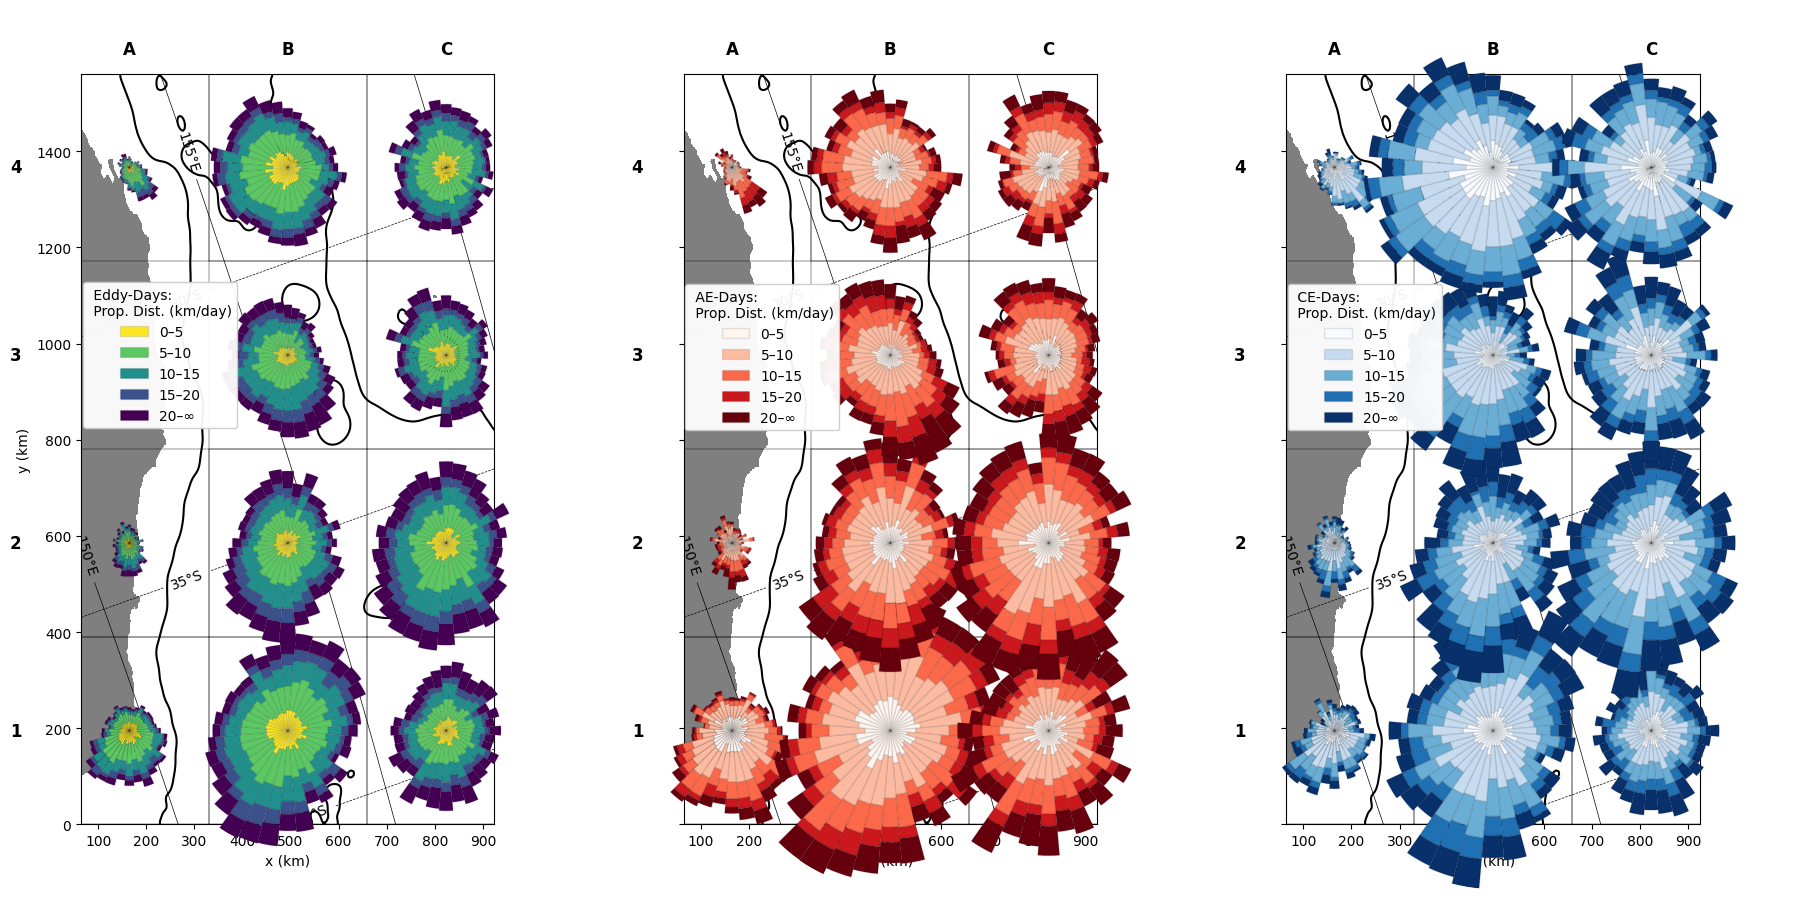

In [15]:
binned_windrose(mag_name='prop_mag', brng_name='prop_bearing', df_data=df_eddies)


### Bottom propogation

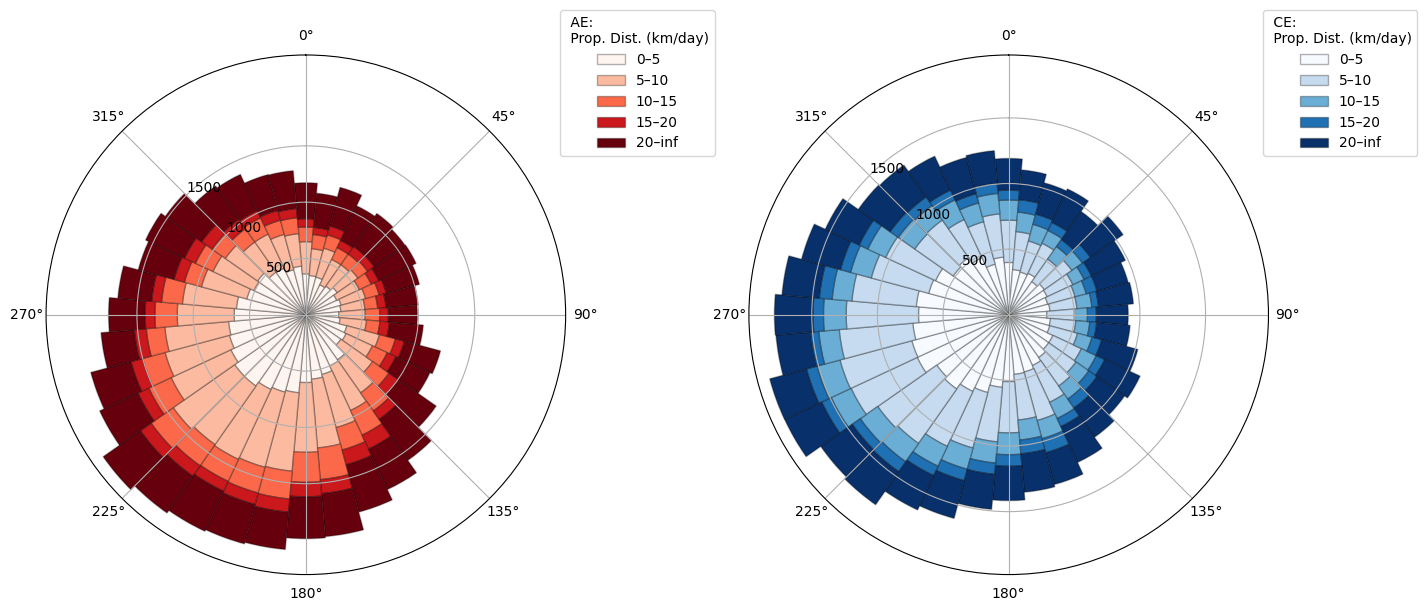

In [16]:
windrose(mag_name='prop_mag_btm', brng_name='prop_bearing_btm', df_data=df_eddies)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


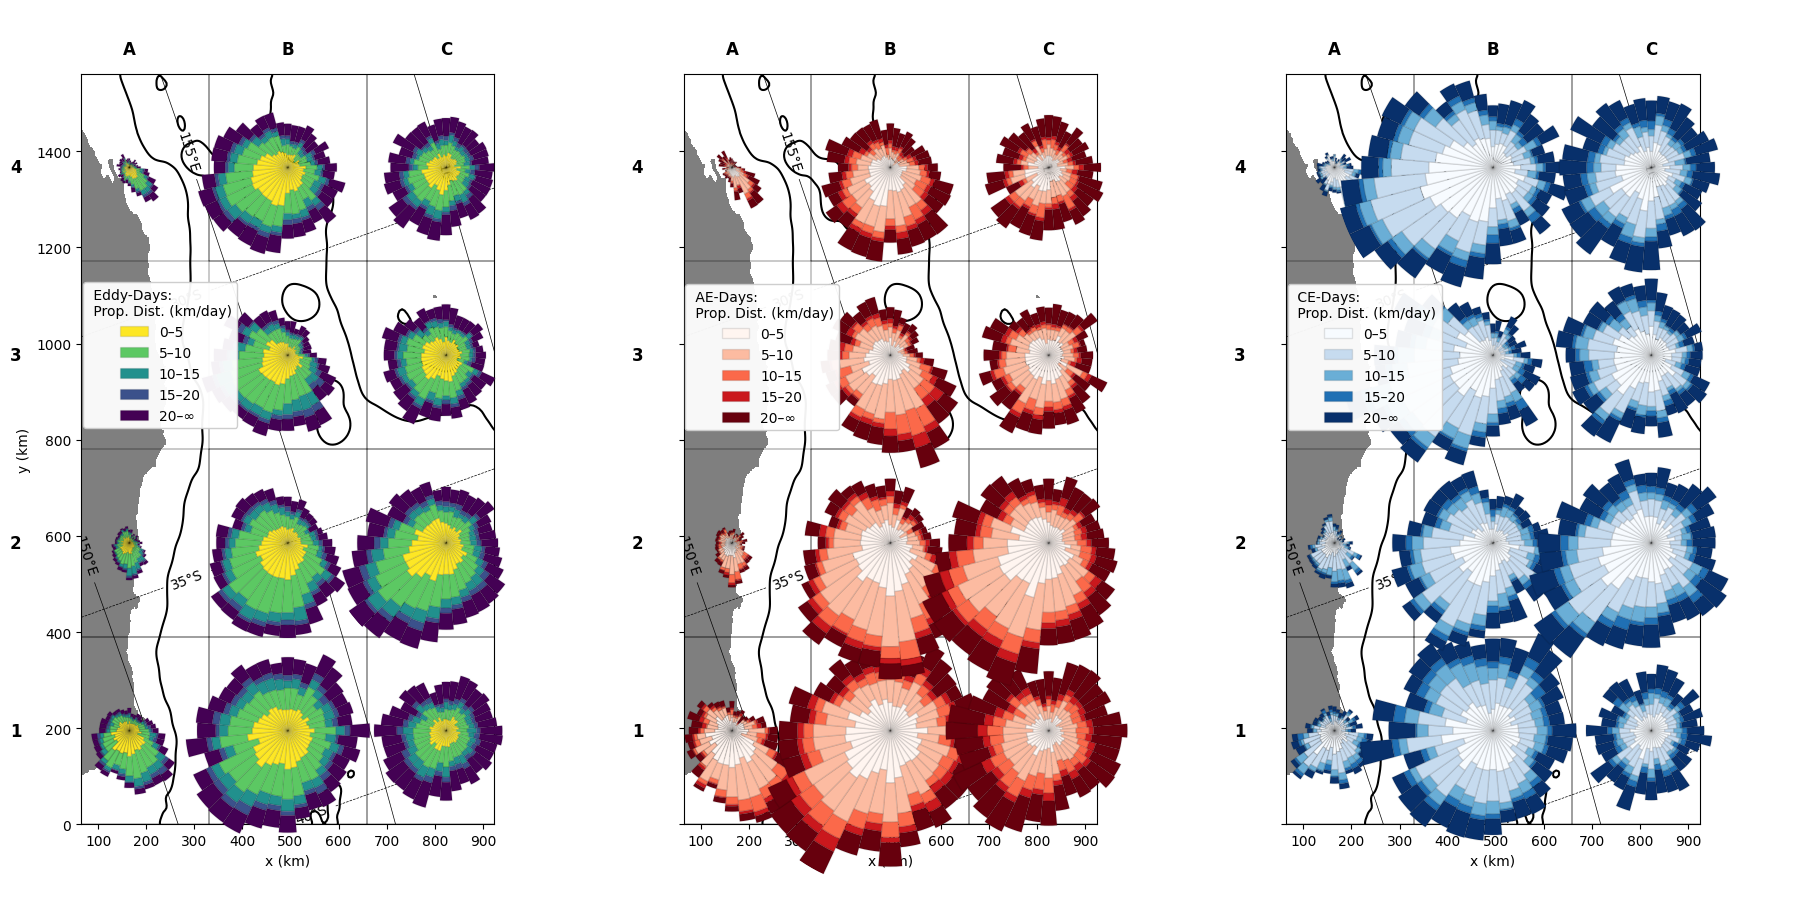

In [17]:
binned_windrose(mag_name='prop_mag_btm', brng_name='prop_bearing_btm', df_data=df_eddies)


### Difference (Inaccurate)

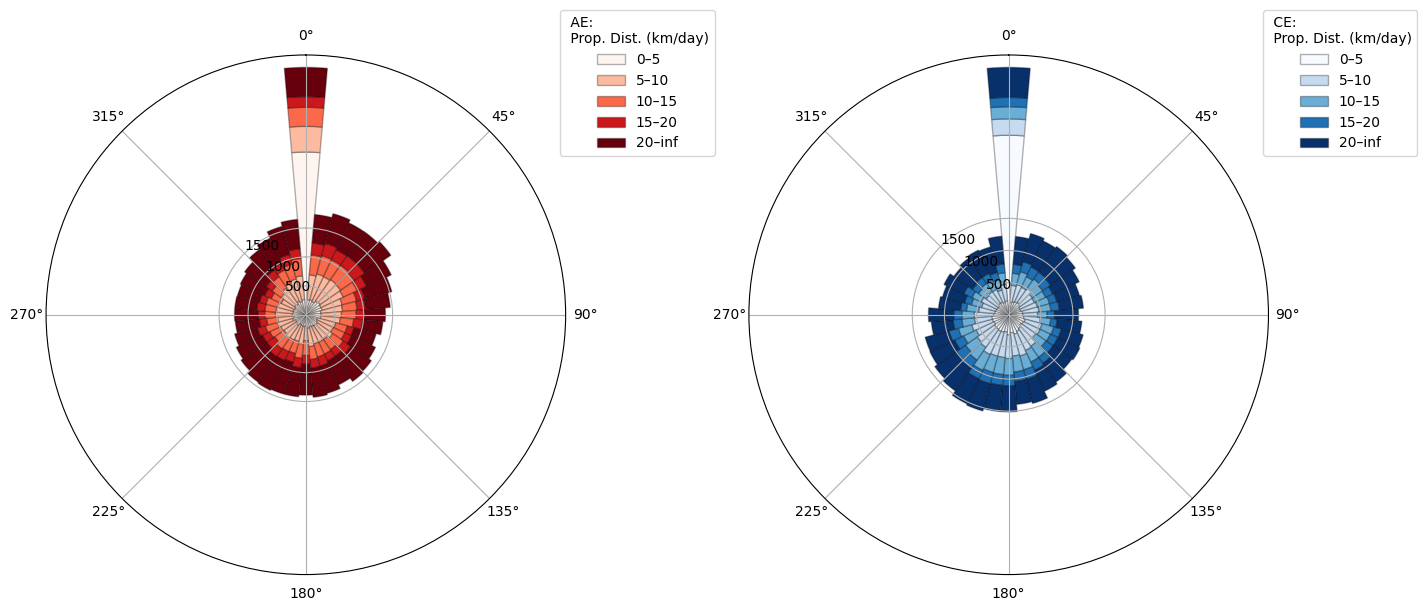

In [18]:
windrose(mag_name='prop_mag_diff', brng_name='prop_bearing_diff', df_data=df_eddies)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


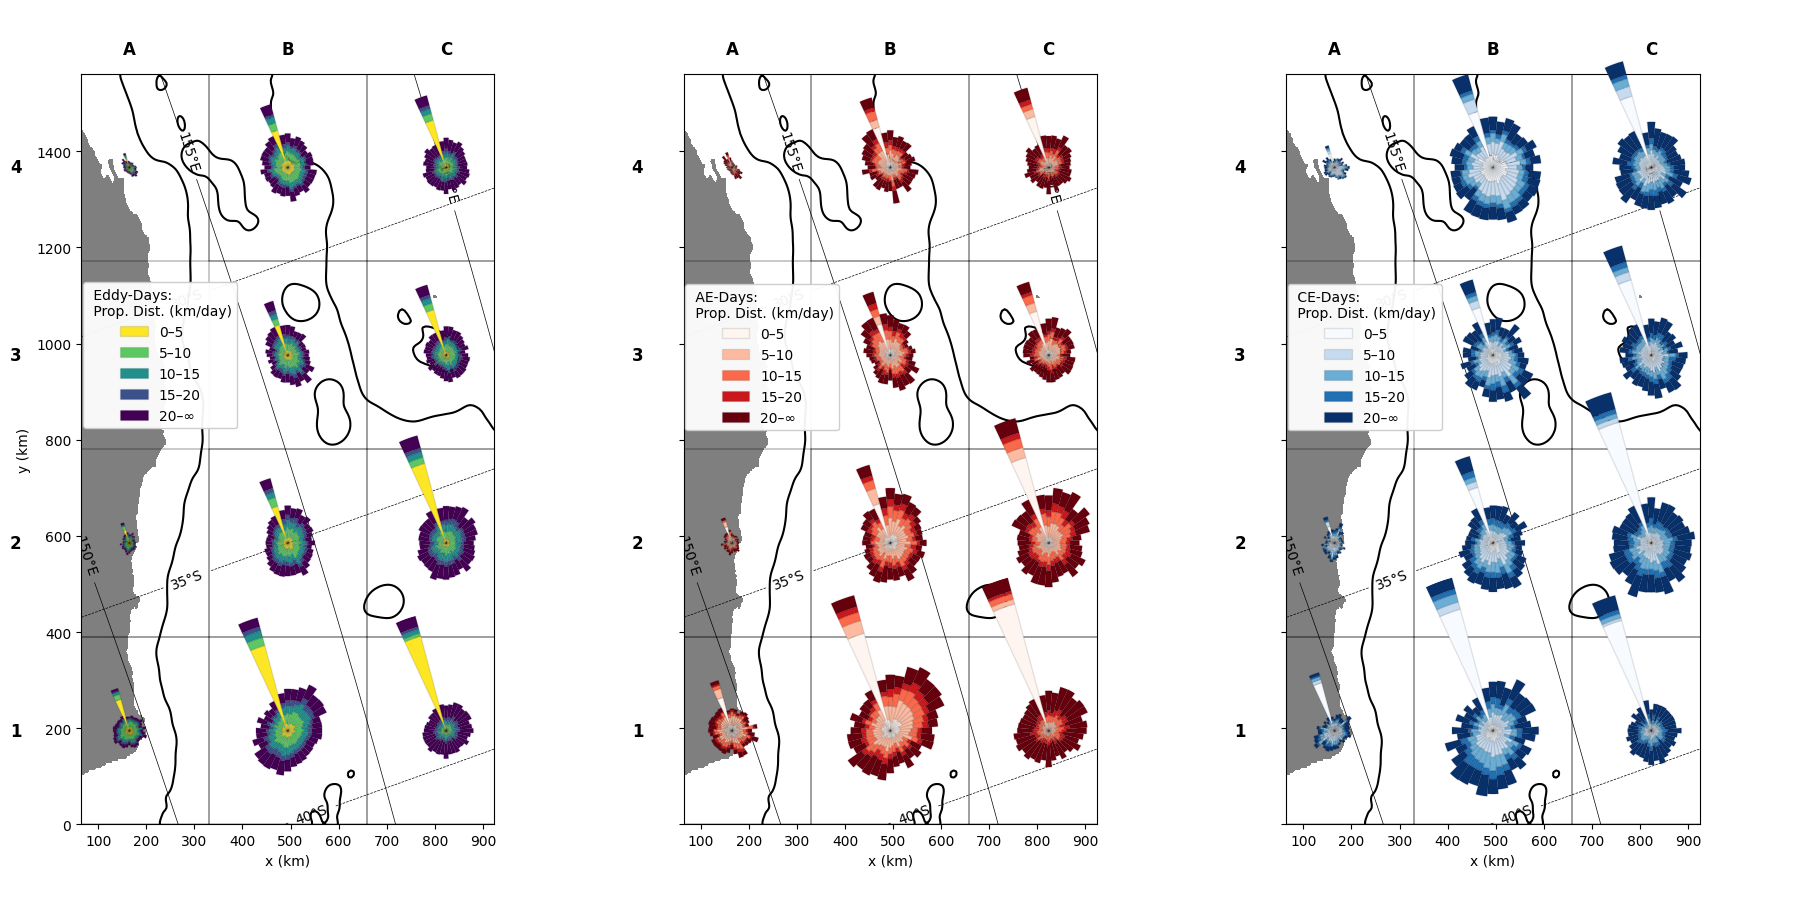

In [19]:
binned_windrose(mag_name='prop_mag_diff', brng_name='prop_bearing_diff', df_data=df_eddies)


In [20]:
# planetary gradient
f = np.transpose(dataset.variables['f'], axes=(1, 0))
dfdx, dfdy = phys_grad(f, X_grid*1e3, Y_grid*1e3, mask_rho)
df_dN = - (np.sin(angle) * dfdx + np.cos(angle) * dfdy)

# beta
beta = df_dN
df_eddies['beta'] = beta[df_eddies.ic, df_eddies.jc]


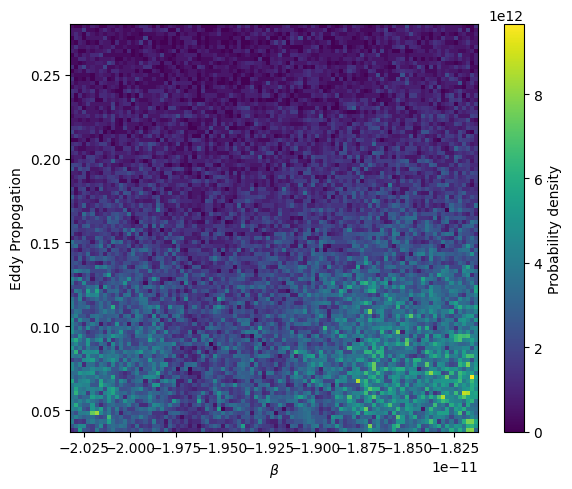

In [21]:
x = df_eddies.beta
y = df_eddies.EddyProp

lo1, hi1 = np.nanpercentile(x, [10, 90])
lo2, hi2 = np.nanpercentile(y, [10, 90])
mask = (x > lo1) & (x < hi1) & (y > lo2) & (y < hi2)

plt.figure(figsize=(6,5))
plt.hist2d(x[mask], y[mask], bins=100, density=True)
plt.colorbar(label='Probability density')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Eddy Propogation')

# plt.plot([-15,15], [-15,15], color='r', lw=.4)

plt.tight_layout()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Min/max tilt per bin:
0.01844788524268357 0.6963808719042685
Min/max tilt per bin:
0.010714909870742534 1.226812451732985


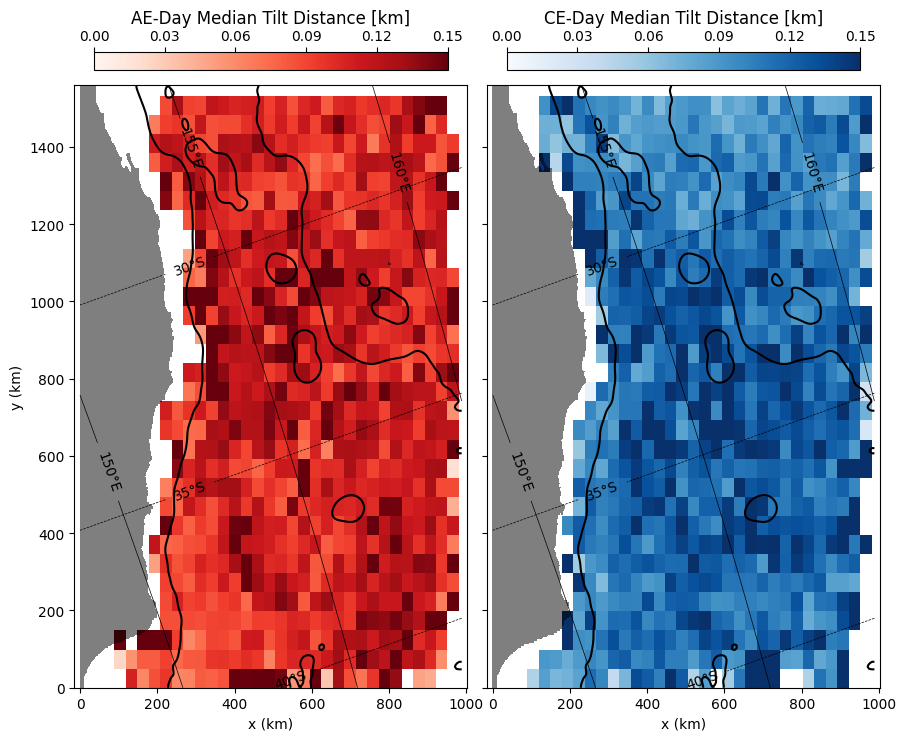

In [22]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: 
            return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])

    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)

    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))

    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))

    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)

    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, .15
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"AE-Day": "Reds", "CE-Day": "Blues"}

def binned_median(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & np.isfinite(v)

    ix, iy, v = ix[ok], iy[ok], v[ok]
    flat = iy * nx + ix

    hmed = np.full(nx * ny, np.nan)
    for k in np.unique(flat):
        hmed[k] = np.nanmedian(v[flat == k])

    return hmed.reshape(ny, nx)

fig, axs = plt.subplots(1, 2, figsize=(9, 8), sharey=True)

for ax, cyc in zip(axs, ['AE-Day', 'CE-Day']):
    df = df_eddies[df_eddies.Cyc == cyc[:2]].copy()
    df = df.sort_values('EddyProp', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_median(df.xc.values, df.yc.values, df.EddyProp.values, xbins, ybins)
    print("Min/max tilt per bin:")
    print(np.nanmin(H), np.nanmax(H))
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm,
                      shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Median Tilt Distance [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()



In [23]:
import xarray as xr
